# **Aplicaciones de la Biometria de la voz** 

> Para probar el modelo de neuronas es necesario ejecutar los apartados siguientes en este orden: Librerias y cargar los datos, Declaracion de funciones, Clasificacion de los datos y el modelo de red de neuronas y entrenamiento. El apartado de test y graficas es para comprobar que el modelo funciona para los ficheros test.

> Si se quiere comproar los waveforms y spectrogramas antes del apartado de modelo de red de neuronas y entrenamiento, se puede ejecutar el apartado de comprobacion de los datos de entrenamiento.



## **Librerias y cargar los datos**

> Se importan las librerias y descargan en zip con los casos de prueba y test que nos han dado

In [ ]:
import os, pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
!pip install tensorflow-io
import tensorflow_io as tfio

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers, models
from IPython import display

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

URL = 'https://drive.upm.es/index.php/s/xFNkMwK7CsufEod/download'
data_dir = pathlib.Path('data/Casos')

if not data_dir.exists():
    tf.keras.utils.get_file(
        'Casos.zip',
        URL,
        extract = True,
        cache_dir ='.', cache_subdir = 'data'
    )

## **Declaración de funciones**

> Se declaran las funciones que se van a utilizar a lo largo del programa

In [ ]:
FRECUENCIA_MUESTREO = 16000
N_RASGOS = 64
LONGITUD_MS_VENTANA_ANALISIS = 200
AUTOTUNE = tf.data.AUTOTUNE

def abrirFicheroAudio_flac(fichero=None):

    audio_binary = tf.io.read_file(fichero)
    audio = tfio.audio.decode_flac(audio_binary, shape=None, dtype = tf.int16, name=None)
    audio_f = tf.cast(tf.squeeze(audio), dtype = tf.float32)
    audio_f = audio_f[:48000]

    return(audio_f)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-3]

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    waveform = abrirFicheroAudio_flac(file_path)
    
    return waveform, label

def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples

  zero_padding = tf.zeros([48000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)

  return spectrogram

def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label==tipo_audio)
  return spectrogram, label_id

def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

## **Clasificación de los datos**

> Se clasifican los datos en tres tipos: entrenamiento, validacion y test

> Como los ficheros de entrenamientos son muchos para procesarlos los hemos dividido en dos partes y cado uno de ellos sera para entrenar un modelo distinto

> Tambien se ha definido el conjunto de etiquetas posibles en los ficheros


In [ ]:
tipo_audio=['spoof','bonafide']

full_data_test  = 'data/test/*/*/*'
full_data_train = 'data/train/*/*/*'

f_train = tf.io.gfile.glob(full_data_train)
filenames_test  = tf.io.gfile.glob(full_data_test)

exp=len(f_train)
num=round(exp/10)
filenames_train= f_train[:exp-num]
filenames_val= f_train[exp-num:exp]

filenames_train1 = tf.random.shuffle(filenames_train)
filenames_test  = tf.random.shuffle(filenames_test)
filenames_val   = tf.random.shuffle(filenames_val)

filenames_train = filenames_train1[:40000]
filenames_train2 = filenames_train1[40000:]
filenames_val = filenames_val[:4000]
filenames_test = filenames_test[:8000]


num_samples_train = len(filenames_train)
num_samples_train2 = len(filenames_train2)
num_samples_test  = len(filenames_test)
num_samples_val  = len(filenames_val)

print('Numero total de casos',exp)
print('Numero total de casos para el entrenamiento del primer modelo:', num_samples_train)
print('Numero total de casos para el entrenamiento del segundo modelo:', num_samples_train2 )
print('Numero total de casos para test:', num_samples_test)
print('Numero total de casos para validacion:', num_samples_val)
print('Etiquetas: ', tipo_audio)

Numero total de casos 81696
Numero total de casos para el entrenamiento del primer modelo: 40000
Numero total de casos para el entrenamiento del segundo modelo: 33526
Numero total de casos para test: 8000
Numero total de casos para validacion: 4000
Etiquetas:  ['spoof', 'bonafide']


## **Comprobación de los datos de entrenamiento**

### Waveforms



> Se procesan los ficheros y se convierten en waveforms. A la hora de procesar el fichero se toman solo los primeros 48000 samples de cada audio con el objetivo de que todos tengan el mismo valor.

> Se muestran los primeros nueve ejemplos.



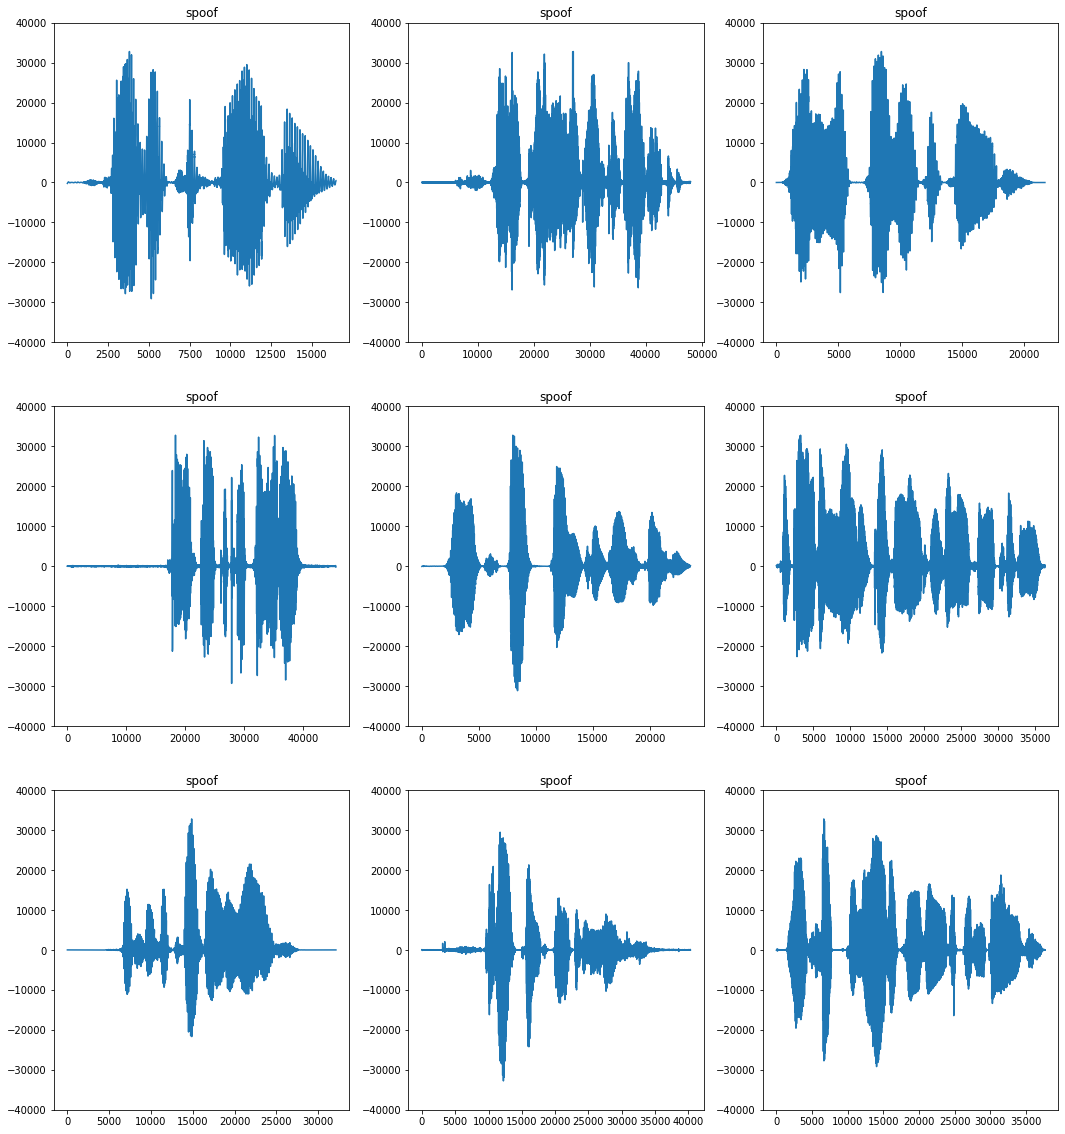

In [ ]:
files_ds  = tf.data.Dataset.from_tensor_slices(filenames_train)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(18, 20))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-40000, 45000, 10000))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

### Spectrograms

> Se saca un espectrograma por cada waveform que tenemos. Se imprimen la etiqueta, la forma del waveform, la forma del espectrograma y una previsualizacion de un audio.

> Tambien se muestra un waveform y su consecuente espectrograma



Audio playback


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log


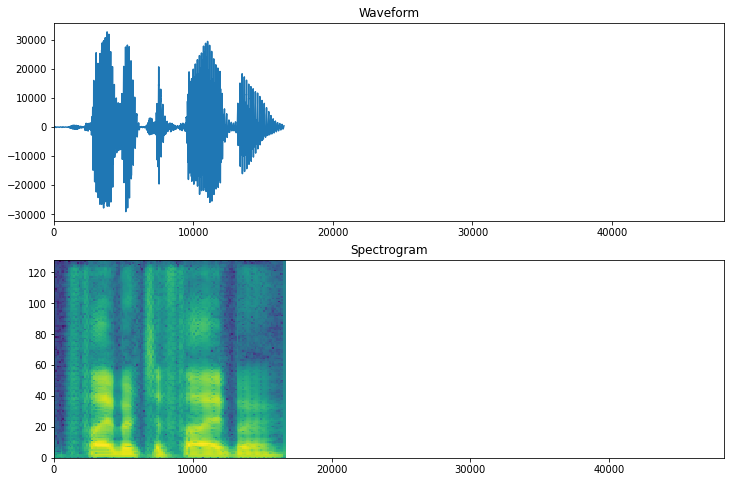

In [ ]:
for audio, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(audio)


#print('Label:', label)
#print('Waveform shape:', audio.shape)
#print('Sprectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(audio, rate=16000))

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(audio.shape[0])
axes[0].plot(timescale, audio.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 48000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

### Labels

> Se le asigna acada espectrogama su correspondiente etiqueta.

> Se muetran nueve ejemplos de espectrogramas con sus etiquetas

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log


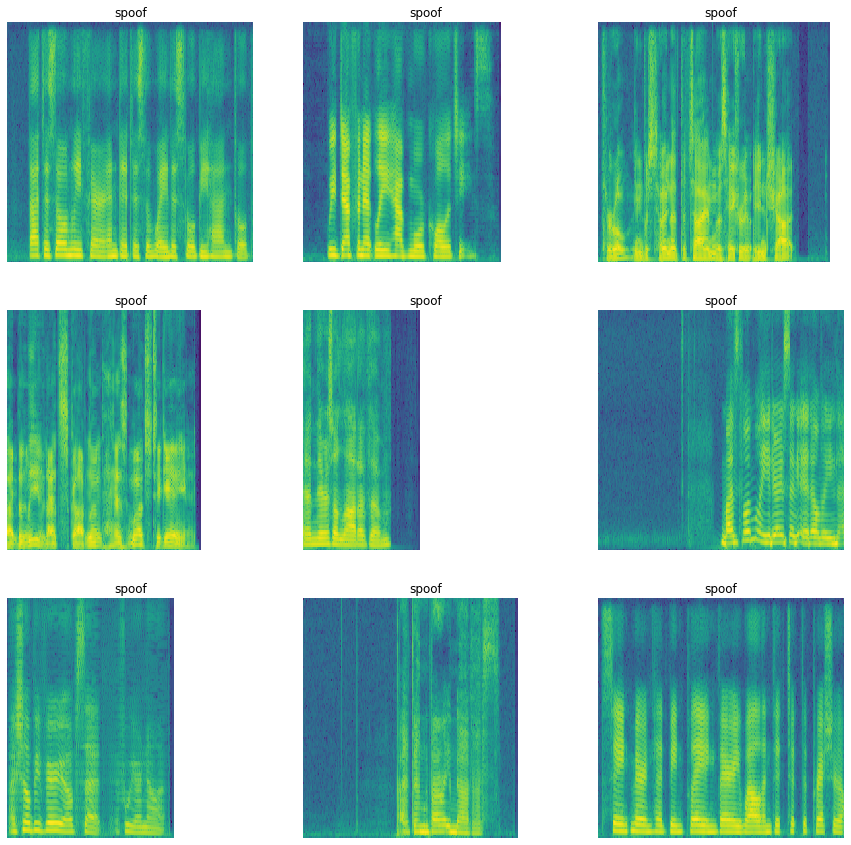

In [ ]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id,num_parallel_calls=AUTOTUNE)

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(tipo_audio[label_id.numpy()])
  ax.axis('off')

plt.show()

## **Modelo de red de neuronas y entrenamiento**

> Para el modelo de red de neuronas se ha utilizado el que se define por defecto para reconocimiento de audios simples, adapatada a nuestra práctica.

> Para el entrenamiento de la red de neuronas se ha decicido dividirlo en dos grupos proporcionados, agregando más casos prueba en el primer modelo de red de neuronas. El motivo es que utilizamos google colab y no podemos entrenar la red de neuronas con tantos ficheros de prueba.

### Data processing

> Antes de pasar al entrenamiento de la red de neuronas, pasamos a procesar el conjunto de entrenamiento y los conjuntos de validación y prueba, `val_ds` y `test_ds` respectivamente.

> Cabe destacar que en este subapartado, hemos definido tanto los conjuntos que se utilizarán en el primero modelo como en el segundo.

In [ ]:
#train1_ds = preprocess_dataset(filenames_train)

# Para primer modelo

files1_ds  = tf.data.Dataset.from_tensor_slices(filenames_train)
waveform1_ds = files1_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
spectrogram1_ds = waveform1_ds.map(get_spectrogram_and_label_id,num_parallel_calls=AUTOTUNE)
train1_ds= spectrogram1_ds

#train2_ds = preprocess_dataset(filenames_train2)

# Para segundo modelo

files2_ds  = tf.data.Dataset.from_tensor_slices(filenames_train2)
waveform2_ds = files2_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
spectrogram2_ds = waveform2_ds.map(get_spectrogram_and_label_id,num_parallel_calls=AUTOTUNE)
train2_ds= spectrogram2_ds

val_ds = preprocess_dataset(filenames_val)
test_ds = preprocess_dataset(filenames_test)

### Definición del modelo 1

> Se pasa agrupar los conjuntos de entrenamiento y validación para la capacitación de modelos. Además, se utilizan las operaciones de `cache()` y `prefetch()` para reducir la latencia de lectura mientras se entrena el modelo.

> Para definir el módelo, y como se ha dicho al principio de esta sección, hemos utilizado una red neuronal convolucional (CNN) simple. El motivo es que durante el desarrollo de la práctica, hemos transformado los archivos de audio en imágenes de espectrograma.

> El modelo tiene definido las siguientes capas de preprocesamiento:
- Una capa de cambio de `Resizing` para reducir la resolución de la entrada y permitir que el modelo se entrene	más rápido.
- Una capa `Normalization` para normalizar cada píxel de la imagen basada en su desviación media y estándar. En este caso, su método `adapt` primero necesitaría ser llamado en los datos de entrenamiento para calcular estadísticas agregadas, es decir, la desviación estándar y su media.

In [ ]:
batch_size = 64
train1_ds = train1_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train1_ds = train1_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

for spectrogram, _ in spectrogram1_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(tipo_audio)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram1_ds.map(lambda x, _: x))

model1 = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model1.summary()


Input shape: (374, 129, 1)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_2 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_2 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)        

### Compilar el modelo y entrenarlo 1

> Se compila el primer modelo que tenemos y se ajusta con los ficheros de entrenamiento y datos de validacion anteriormente declarados
con seis epocas y una parada temprana con dos de paciencia, que significa que si la tasa de perdida no mejora durante dos epocas seguidas se parara
antes de procesar las seis epocas


In [ ]:
model1.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

EPOCHS = 6
history = model1.fit(
    train1_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/6
625/625 [==============================] - 501s 799ms/step - loss: 0.2548 - accuracy: 0.9002 - val_loss: 0.0309 - val_accuracy: 0.9923
Epoch 2/6
625/625 [==============================] - 132s 211ms/step - loss: 0.2042 - accuracy: 0.9094 - val_loss: 0.0220 - val_accuracy: 0.9920
Epoch 3/6
625/625 [==============================] - 132s 212ms/step - loss: 0.1718 - accuracy: 0.9237 - val_loss: 0.0165 - val_accuracy: 0.9923
Epoch 4/6
625/625 [==============================] - 139s 223ms/step - loss: 0.1427 - accuracy: 0.9372 - val_loss: 0.0157 - val_accuracy: 0.9935
Epoch 5/6
625/625 [==============================] - 142s 228ms/step - loss: 0.1136 - accuracy: 0.9528 - val_loss: 0.0172 - val_accuracy: 0.9933
Epoch 6/6
625/625 [==============================] - 138s 221ms/step - loss: 0.0923 - accuracy: 0.9636 - val_loss: 0.0126 - val_accuracy: 0.9935


### Gráficas 1

> Se sacan las métricas del resultado anterior mostrando como evoluciona la perdida de los valores de entrenamiento, `loss`, y la perdida de los valores de validacion, `val_loss`.

> Ademas sacamos el porcentaje de precision del los ficheros test.

> Por ultimo, sacamos una gráfica de confusión en la que se muestran el como se ha predicho las distintas etiquetas y cuales eran sus verdaderas etiquetas.
Si miramos la gráfica podemos apreciar que los valores que caen en la diagonal son los que se han predicho la etiqueta de manera correcta. Y los de la diagonal
secundaria son los que han predicho la etiqueta de manera errónea.

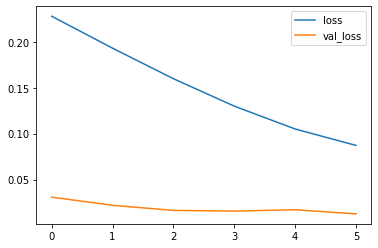

Test set accuracy: 93%


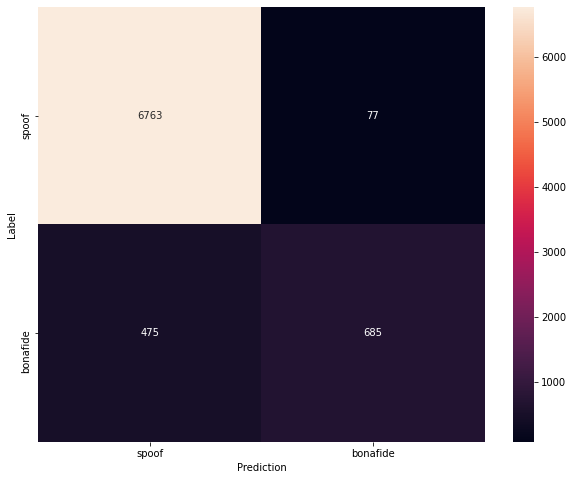

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model1.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=tipo_audio, yticklabels=tipo_audio, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Definición del modelo 2

> El segundo modelo de la red de neuronas, explicado al principio de este apartado, es idéntico al primer modelo definido, pero utilizando sus correspondientes conjuntos de entrenamiento.

In [ ]:
batch_size = 64
train2_ds = train2_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train2_ds = train2_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

for spectrogram, _ in spectrogram2_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(tipo_audio)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram2_ds.map(lambda x, _: x))

model2 = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model2.summary()


Input shape: (374, 129, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_1 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)        

### Compilar el modelo y entrenarlo 2

In [ ]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

EPOCHS = 6
history = model2.fit(
    train2_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/6
170/524 [========>.....................] - ETA: 4:26 - loss: 0.2739 - accuracy: 0.8839

### Gráficas 2

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

y_pred = np.argmax(model2.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=tipo_audio, yticklabels=tipo_audio, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()